In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install segmentation-models-pytorch


In [3]:
import os
import random
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import cv2 as cv
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
import segmentation_models_pytorch as smp

In [4]:
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

In [5]:
class dataUpload:

    def __init__(self, images_path, masks_path):
        self.image_path = images_path
        self.mask_path = masks_path
        self.images_array, self.masks_array = [], []

    def loadData(self):
        for i in tqdm(os.listdir(self.image_path)):
            image = os.path.join(self.image_path, i)
            image = cv.imread(image)

            self.images_array.append(image)

        for m in tqdm(os.listdir(self.mask_path)):
            mask = os.path.join(self.mask_path, m)
            mask = cv.imread(mask)

            self.masks_array.append(mask)

        return self.images_array, self.masks_array

In [6]:
def allAboutData(train_images_path, train_masks_path, val_images_path, val_masks_path, val_fraction=0.6):

    trainLoader = dataUpload(train_images_path, train_masks_path)
    train_images, train_masks = trainLoader.loadData()

    val_testLoader = dataUpload(val_test_images_path, val_test_masks_path)
    val_test_images, val_test_masks = val_testLoader.loadData()

    def val_test_split(val_fraction):
        val_test_zip = [[image, mask] for image, mask in zip(val_test_images, val_test_masks)]

        val_size = int(val_fraction * len(val_test_zip))
        test_size = len(val_test_zip) - val_size
        valset, testset = torch.utils.data.random_split(val_test_zip, (val_size, test_size), generator=torch.Generator().manual_seed(0))

        val_images, val_masks = [], []
        test_images, test_masks = [], []

        for val_elem in valset:

            val_images.append(val_elem[0])
            val_masks.append(val_elem[1])

        for test_elem in testset:

            test_images.append(test_elem[0])
            test_masks.append(test_elem[1])

        return val_images, val_masks, test_images, test_masks

    val_images, val_masks, test_images, test_masks = val_test_split(val_fraction)
    return train_images, train_masks, val_images, val_masks, test_images, test_masks

In [7]:
def resizeImages(images, masks, height, width):

    for i in range(len(images)):
        images[i] = cv.resize(images[i], (width, height))
        masks[i] = cv.resize(masks[i], (width, height))

    return images, masks

def toGrayScale(images, masks):
    gray_images, gray_masks = [], []
    for image, mask in zip(images, masks):
        gray_images.append(cv.cvtColor(image, cv.COLOR_BGR2GRAY))
        gray_masks.append(cv.cvtColor(mask, cv.COLOR_BGR2GRAY))

    return gray_images, gray_masks

def augmentImages(images, masks, translate, rotate):
    if translate:
        images, masks = translateData(images, masks)
    if rotate:
        images, masks = rotateData(images, masks)

    return images, masks

def translateData(images, masks):
    translated_images, translated_masks = [], []

    for image, mask in zip(images, masks):
        translated_img, translated_mask = translateImage(image, mask)
        translated_images.append(translated_img)
        translated_masks.append(translated_mask)

    return images + translated_images, masks + translated_masks

def rotateData(images, masks):
    rotated_images, rotated_masks = [], []

    for image, mask in zip(images, masks):
        rot_img, rot_mask = rotateImage(image, mask)
        rotated_images.append(rot_img)
        rotated_masks.append(rot_mask)

    return images + rotated_images, masks + rotated_masks

def translateImage(image, mask):
    height, width = image.shape[:2]

    translate_value = np.random.rand() / 2
    width_translate, height_translate = width * translate_value, height * translate_value
    tx, ty = width / width_translate, height / height_translate
    translation_matrix = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)

    translated_image = cv.warpAffine(src=image, M=translation_matrix, dsize=(width, height))
    translated_mask = cv.warpAffine(src=mask, M=translation_matrix, dsize=(width, height))

    return translated_image, translated_mask

def rotateImage(image, mask):
    height, width = image.shape[:2]

    center = (width/2, height/2)
    angle = np.random.rand() * 90
    rotate_matrix = cv.getRotationMatrix2D(center=center, angle=angle, scale=1)

    rotated_image = cv.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
    rotated_mask = cv.warpAffine(src=mask, M=rotate_matrix, dsize=(width, height))

    return rotated_image, rotated_mask

def scaleValues(images, masks):
    return images / 255.0, masks / 255.0

In [8]:
def preProcess(images, masks, height, width, augment=False, translate=False, rotate=False):
    images, masks = resizeImages(images, masks, height, width)
    num_channels = 1

    images, masks = toGrayScale(images, masks)

    if augment:
        images, masks = augmentImages(images, masks, translate, rotate)

    images, masks = np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)
    images /= 255.0
    masks /= 255.0
    return images, masks, num_channels

In [9]:
def dataGenerator(images, masks, batch_size, shuffle=True, train=True):
    X, Y = images, masks

    index = 0
    num_images = len(images)
    indices = [*range(num_images)]
    if shuffle:
        random.shuffle(indices)

    while True:
        if index >= num_images:
            index = 0
            if shuffle:
                random.shuffle(indices)
        index += 1

        for i in range(0, num_images, batch_size):
            try:
                x = X[indices[i:i+batch_size]]
                y = Y[indices[i:i+batch_size]]
            except:
                x = X[indices[i:]]
                y = Y[indices[i:]]

            if len(x) != batch_size or i == num_images - batch_size:
                yield x, y, 1
            else:
                yield x, y, 0


In [10]:
class convBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.conv1(x.float()))
        x = self.relu(self.conv2(x))
        return x

In [11]:
class encoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer = convBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = self.conv_layer(x)
        p = self.pool(x)
        return x, p

In [12]:
class decoderBlock(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv_layer = convBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.convTranspose(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv_layer(x)
        return x

In [13]:
class U_Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.encode1 = encoderBlock(1, 32)
        self.encode2 = encoderBlock(32, 64)
        self.encode3 = encoderBlock(64, 128)
        self.encode4 = encoderBlock(128, 256)

        self.bottleneck = convBlock(256, 512)

        self.decode1 = decoderBlock(512, 256)
        self.decode2 = decoderBlock(256, 128)
        self.decode3 = decoderBlock(128, 64)
        self.decode4 = decoderBlock(64, 32)
        self.relu = nn.ReLU()

        self.classify = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.float()

    def forward(self, x):
        x1, p1 = self.encode1(x)
        x2, p2 = self.encode2(p1)
        x3, p3 = self.encode3(p2)
        x4, p4 = self.encode4(p3)

        b = self.bottleneck(p4)

        d1 = self.decode1(b, x4)
        d2 = self.decode2(d1, x3)
        d3 = self.decode3(d2, x2)
        d4 = self.decode4(d3, x1)

        output = self.classify(d4)
        return output

In [14]:
def modelDefinition(model_class=U_Net, learning_rate=0.001, pretrained=True, schedule=True):
    if pretrained:
        model = smp.FPN(encoder_weights='imagenet', in_channels=1).to(device)
    else:
        model = model_class().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if schedule:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=30, cooldown=10)
        return model, loss_fn, optimizer, scheduler
    else:
        return model, loss_fn, optimizer

In [15]:
def trainingLoop(train_generator, model, loss_fn, optimizer, num_epochs, height, width, num_channels, train_batch_size, val_images, val_masks, val_batch_size, scheduler=None):
    train_loss, val_loss = [], []
    train_DS, val_DS = [], []

    for epoch in range(num_epochs):
        epoch_loss, num_images, dice_score = 0, 0, 0

        while True:
            X, Y, count = next(train_generator)
            X = torch.tensor(X)
            Y = torch.tensor(Y)

            X = torch.reshape(X, (-1, 1, height, width)).to(device)
            Y = torch.reshape(Y, (-1, 1, height, width)).to(device)

            optimizer.zero_grad()

            output = model(X)
            sigmoid = nn.Sigmoid()
            sigmoided_output = sigmoid(output)
            dice_score += diceScore(sigmoided_output, Y).item()

            loss = loss_fn(output, Y)
            epoch_loss += X.size(dim=0) * loss

            loss.backward()
            optimizer.step()

            num_images += X.size(dim=0)
            if count == 1:
                break
        print(f"Loss After {epoch + 1} Epochs: {epoch_loss / num_images: .6f}")
        if scheduler is not None:
            scheduler.step(epoch_loss/num_images)
        val_generator = dataGenerator(val_images, val_masks, val_batch_size, shuffle=False, train=False)
        valset_loss, valset_dice_score = valLoop(val_generator, loss_fn, model, height, width, val_batch_size, called_by_train=True)

        train_loss.append(epoch_loss / num_images)
        train_DS.append(dice_score / num_images)
        val_loss.append(valset_loss)
        val_DS.append(valset_dice_score)

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), r'C:\Users\nikhi\OneDrive\Documents\OneNote Notebooks\Comouflage\FPN_With_Calculated_Scheduling\FPN_GRAY_' + str(epoch+1) + '_Epochs_BCEWithLogits.pt')

    return model, train_loss, train_DS, val_loss, val_DS

In [16]:
def valLoop(val_generator, loss_fn, model, height, width, val_batch_size, called_by_train=False):
    Y_pred = []
    num_images, loss, dice_score = 0, 0, 0

    with torch.no_grad():
        while True:
            X, Y, count = next(val_generator)

            X = torch.tensor(X)
            X = torch.reshape(X, (-1, 1, height, width)).to(device)
            Y = torch.tensor(Y)
            Y = torch.reshape(Y, (-1, 1, height, width)).to(device)

            Y_output = model(X)
            num_images += X.size(dim=0)
            loss += loss_fn(Y_output, Y).item() * X.size(dim=0)

            Y_output = torch.reshape(Y_output, (-1, height, width, 1))
            sigmoid = nn.Sigmoid()
            Y_output = sigmoid(Y_output)
            dice_score += diceScore(Y_output, Y)

            Y_pred += list(np.reshape(Y_output.detach().cpu().numpy(), (-1, height, width)))

            if count == 1:
                break

    if called_by_train:
        return loss / num_images, dice_score / num_images
    else:
        return Y_pred, dice_score / num_images

In [17]:
def diceScore(Y_output, Y):
    gamma = 1
    batch_size = Y_output.size(dim=0)

    model_outputs = Y_output.reshape(batch_size, -1).float()
    original_outputs = Y.reshape(batch_size, -1).float()
    intersection = (model_outputs * original_outputs).sum().float()
    return batch_size * (2 * intersection + gamma) / (model_outputs.sum() + original_outputs.sum() + gamma)

In [48]:
def displayOutputs(val_images, val_masks, Y_pred, num_show):
    num_images = len(val_images)
    indices = np.random.randint(0, num_images, size=num_show)

    for index in range(len(indices)):
        cv.imshow('Grayscale Image', cv.resize(val_images[index], (256, 256)))

        cv.imshow('Original Mask', cv.resize(val_masks[index], (256, 256)))
        cv.moveWindow('Original Mask', 300, 0)

        cv.imshow('Predicted Mask', cv.resize((Y_pred[index] * 255).astype(np.uint8), (256, 256)))
        cv.moveWindow('Predicted Mask', 300, 300)
        cv.waitKey(2000)

    cv.destroyAllWindows()

In [19]:
train_images_path = '/content/drive/MyDrive/Camouflage/Images/Train'
train_masks_path = '/content/drive/MyDrive/Camouflage/GT'
val_test_images_path = '/content/drive/MyDrive/Camouflage/Images/Test'
val_test_masks_path = '/content/drive/MyDrive/Camouflage/GT'

In [20]:
height, width = 64, 64
learning_rate = 0.0005
num_epochs =4

train_batch_size, val_batch_size, test_batch_size = 16, 8, 8
val_fraction = 1.0
shuffle = True

augment = True
translate, rotate = True, True

num_show = 10
pretrain = True
schedule = True

In [21]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = allAboutData(train_images_path, train_masks_path, val_test_images_path, val_test_masks_path, val_fraction=val_fraction)

100%|██████████| 1250/1250 [00:07<00:00, 166.16it/s]


In [22]:
train_images, train_masks, train_num_channels = preProcess(train_images, train_masks, height, width, augment=augment, translate=translate, rotate=rotate)
val_images, val_masks, val_num_channels = preProcess(val_images, val_masks, height, width)
test_images, test_masks, test_num_channels = preProcess(test_images, test_masks, height, width)

In [23]:
train_generator = dataGenerator(train_images, train_masks, train_batch_size, shuffle=shuffle, train=True)
val_generator = dataGenerator(val_images, val_masks, val_batch_size, shuffle=False, train=False)
test_generator = dataGenerator(test_images, test_masks, test_batch_size, shuffle=False, train=False)
valUsingTrain_generator = dataGenerator(train_images, train_masks, val_batch_size, shuffle=False, train=False)

In [24]:
if schedule:
    model, loss_fn, optimizer, scheduler = modelDefinition(model_class=U_Net, learning_rate=learning_rate, pretrained=pretrain, schedule=schedule)
else:
    model, loss_fn, optimizer = modelDefinition(model_class=U_Net, learning_rate=learning_rate, pretrained=pretrain, schedule=schedule)
    scheduler = None

In [25]:
print(model, scheduler)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [26]:
model, train_loss, train_DS, val_loss, val_DS = trainingLoop(train_generator, model, loss_fn, optimizer, num_epochs, height, width, train_num_channels, train_batch_size, val_images, val_masks, val_batch_size, scheduler)

Loss After 1 Epochs:  0.436055
Loss After 2 Epochs:  0.347889
Loss After 3 Epochs:  0.329325
Loss After 4 Epochs:  0.310639


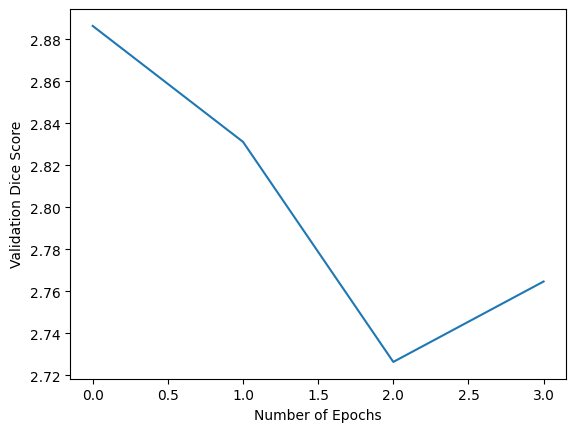

In [27]:
X = [*range(len(train_loss))]
val_DS = [val_DS[i] * val_batch_size for i in range(len(val_DS))]
plt.plot(X, val_DS)
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Dice Score')
plt.savefig(r'C:\Users\nikhi\OneDrive\Documents\OneNote Notebooks\Comouflage\Val_DS_FPN_GRAY.png')

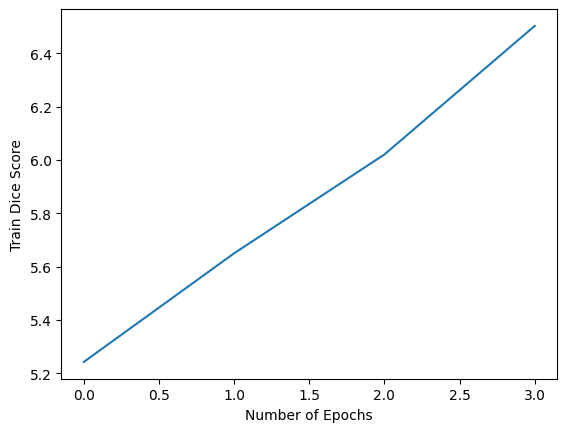

In [28]:
X = [*range(len(train_loss))]
train_DS = [train_DS[i] * train_batch_size for i in range(len(train_DS))]
plt.plot(X, train_DS)
plt.xlabel('Number of Epochs')
plt.ylabel('Train Dice Score')
plt.savefig(r'C:\Users\nikhi\OneDrive\Documents\OneNote Notebooks\Comouflage\Train_DS_FPN_GRAY.png')

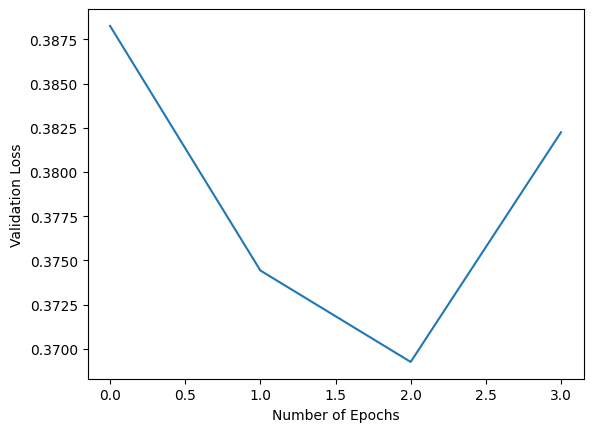

In [30]:
X = [*range(len(train_loss))]
plt.plot(X, val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')
plt.savefig(r'C:\Users\nikhi\OneDrive\Documents\OneNote Notebooks\Comouflage\Val_Loss_FPN_GRAY.png')

In [32]:
def fixLists(input_list):
    fixed_list = []
    for elem in input_list:
        try:
            fixed_list.append(elem.detach().cpu().item())
        except:
            fixed_list.append(elem)
    return fixed_list

In [33]:
train_loss, train_DS, val_loss, val_DS = fixLists(train_loss), fixLists(train_DS), fixLists(val_loss), fixLists(val_DS)

In [34]:
Y_pred, dice_score = valLoop(val_generator, loss_fn, model, height, width, val_batch_size, called_by_train=False)